In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import sys, os
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [98]:
LINE_SEGMENTS = 1
LINE_WIDTH = 2
RK4 = ''
DPI = 300
def get_args():
    return {'input_dim': 2,
         'output_dim': 2,   
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 100,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
          'save_dir': '{.}'
            #.format(THIS_DIR), 
         
         }

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView(get_args())        

In [4]:
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp=scipy.integrate.solve_ivp
from torch.autograd import Variable
import autograd
import autograd.numpy as np

# Hamiltonian

def Hamiltonian(y):
    q, p = np.split(y,2)
    H = p**2 + q**2
    return H

# Dynamics of Hamiltonian == gradiant of Hamiltonian

def grad_Hamiltonian(t,yold):
       
      
    
    dcoords = autograd.grad(Hamiltonian)(yold)
    dHdq, dHdp = np.split(dcoords,2)
    S = np.concatenate([dHdp, -dHdq], axis=-1)
    return S



# trajectory

def trajectory(t,y0):
   
    
    
    noise_std=0.1
    sol = solve_ivp(fun=grad_Hamiltonian,t_span=t,y0=y0)
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    q_new += np.random.randn(*q_new.shape)*noise_std
    p_new += np.random.randn(*p_new.shape)*noise_std
    return q_new,p_new,dq,dp
    








In [49]:
class model(nn.Module): 
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.in_size=in_size
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, out_size)
        
        
        
    def forward(self, xb):
        
        out = self.linear1(xb)
        out = torch.tanh(out)
        out = self.linear2(out)
        out = torch.tanh(out)
        out = self.linear3(out)
        return out
    
    def HNN(self,x, t=None):
        y=self.forward(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        F1,F2= y.split(1,1)
        solenoidal_field = torch.zeros_like(x)
        dy = torch.autograd.grad(F2.sum(), x, create_graph=True)[0]
    
        n=self.in_size
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        solenoidal_field = dy @ M.t()
    
        return solenoidal_field

In [50]:
def get_dataset(seed=0, samples=50, test_split=0.2):    # inja 50ta nemune random az file data bardashte be surste zoje moratab p&q va dp&dq neveshte va 20 darsad oona ro dade test ghara dade
    data = {'meta': locals()}
    t=[0,10]
    y0=np.asarray([1.0,0.0])
    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dq, dp= trajectory(t,y0)
        xs.append( np.stack( [q, p]).T )
        dxs.append( np.stack( [dq, dp]).T )
        
    data['q&p'] = np.concatenate(xs)
    data['dq&dp'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['q&p']) * test_split)
    split_data = {}
    for k in ['q&p', 'dq&dp']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data


In [51]:
def loss_fn(u, v):
    return (u-v).pow(2).mean()

In [91]:
 def fit(epochs, lr, model , opt_func=torch.optim.Adam):
    """Train the model using gradient descent"""
    
    data = get_dataset()
    train_dl = torch.tensor(data['q&p'], requires_grad=True, dtype=torch.float32)
    test_dl = torch.tensor( data['test_q&p'], requires_grad=True, dtype=torch.float32)
    train_dl_dxdt = torch.Tensor(data['dq&dp'])
    test_dl_dxdt = torch.Tensor(data['test_dq&dp'])
    
    loss_train_np=[epochs]
    loss_test_np=[epochs]
    stats = {'train_loss': [], 'test_loss': []}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        
        # Training Phase 
        train_data=model.HNN(train_dl)
        loss_train = loss_fn(train_data,train_dl_dxdt)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        
        
        # Test phase
        test_data=model.HNN(test_dl)
        loss_test = loss_fn(test_data,test_dl_dxdt)
        loss_test.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        stats['train_loss'].append(loss_train.item())
        stats['test_loss'].append(loss_test.item())
        print("epoch {}, train_loss {:.4e}, test_loss {:.4e}".format(epoch, loss_train.item(), loss_test.item()))
        loss_train_np.append(loss_train.item())
        loss_test_np.append(loss_test.item())
    
    os.makedirs(args.save_dir) 
    label = '-train_hnn_model'
    path = '{}/{}{}.tar'.format(args.save_dir,args.name, label)
    torch.save(model.state_dict(), path)
    
    return loss_train_np,loss_test_np
    

In [92]:

HNN_model=model(args.input_dim, args.hidden_dim, args.output_dim)  
loss_trainList,loss_testList=fit(epochs=args.total_steps, lr=args.learn_rate,model=HNN_model)

epoch 0, train_loss 1.9396e+00, test_loss 1.7337e+00
epoch 1, train_loss 1.5468e+00, test_loss 1.3744e+00
epoch 2, train_loss 1.2141e+00, test_loss 1.0643e+00
epoch 3, train_loss 9.2551e-01, test_loss 7.9576e-01
epoch 4, train_loss 6.7658e-01, test_loss 5.6513e-01
epoch 5, train_loss 4.6379e-01, test_loss 3.6934e-01
epoch 6, train_loss 2.8602e-01, test_loss 2.1016e-01
epoch 7, train_loss 1.4866e-01, test_loss 9.6122e-02
epoch 8, train_loss 6.2038e-02, test_loss 3.7170e-02
epoch 9, train_loss 3.2210e-02, test_loss 3.2923e-02
epoch 10, train_loss 4.8391e-02, test_loss 6.1654e-02
epoch 11, train_loss 7.9025e-02, test_loss 8.7611e-02
epoch 12, train_loss 9.2747e-02, test_loss 8.9390e-02
epoch 13, train_loss 8.1747e-02, test_loss 7.0235e-02
epoch 14, train_loss 5.7438e-02, test_loss 4.5395e-02
epoch 15, train_loss 3.5715e-02, test_loss 2.8852e-02
epoch 16, train_loss 2.6376e-02, test_loss 2.5456e-02
epoch 17, train_loss 2.8738e-02, test_loss 3.0317e-02
epoch 18, train_loss 3.5184e-02, test_

Text(0.5, 1.0, 'Hamiltonian NN,loss')

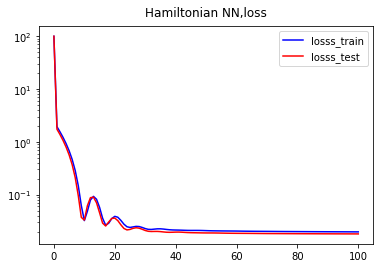

In [97]:

plt.plot(loss_trainList,'b', label="losss_train")
plt.plot(loss_testList,'r',label="losss_test")
plt.legend()
plt.yscale('log')
plt.title("Hamiltonian NN,loss", pad=10)

In [62]:
def get_model(args):

   
    hnn_model=model(args.input_dim, args.hidden_dim, args.output_dim)
    label = '-train_hnn_model'
    path = '{}/{}{}.tar'.format(args.save_dir,args.name, label)
    hnn_model.load_state_dict(torch.load(path))
    return hnn_model

In [63]:
def integrate_model(model, t_span, y0):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.HNN(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval= np.linspace(t_span[0],t_span[1],2000))

In [100]:
hnn_model = get_model(args)
t_span = [0,20]
y0 = np.asarray([1., 0])
hnn_ivp = integrate_model(hnn_model, t_span, y0)
hnn_x=hnn_ivp['y'].T

Text(0.5, 1.0, 'Hamiltonian NN')

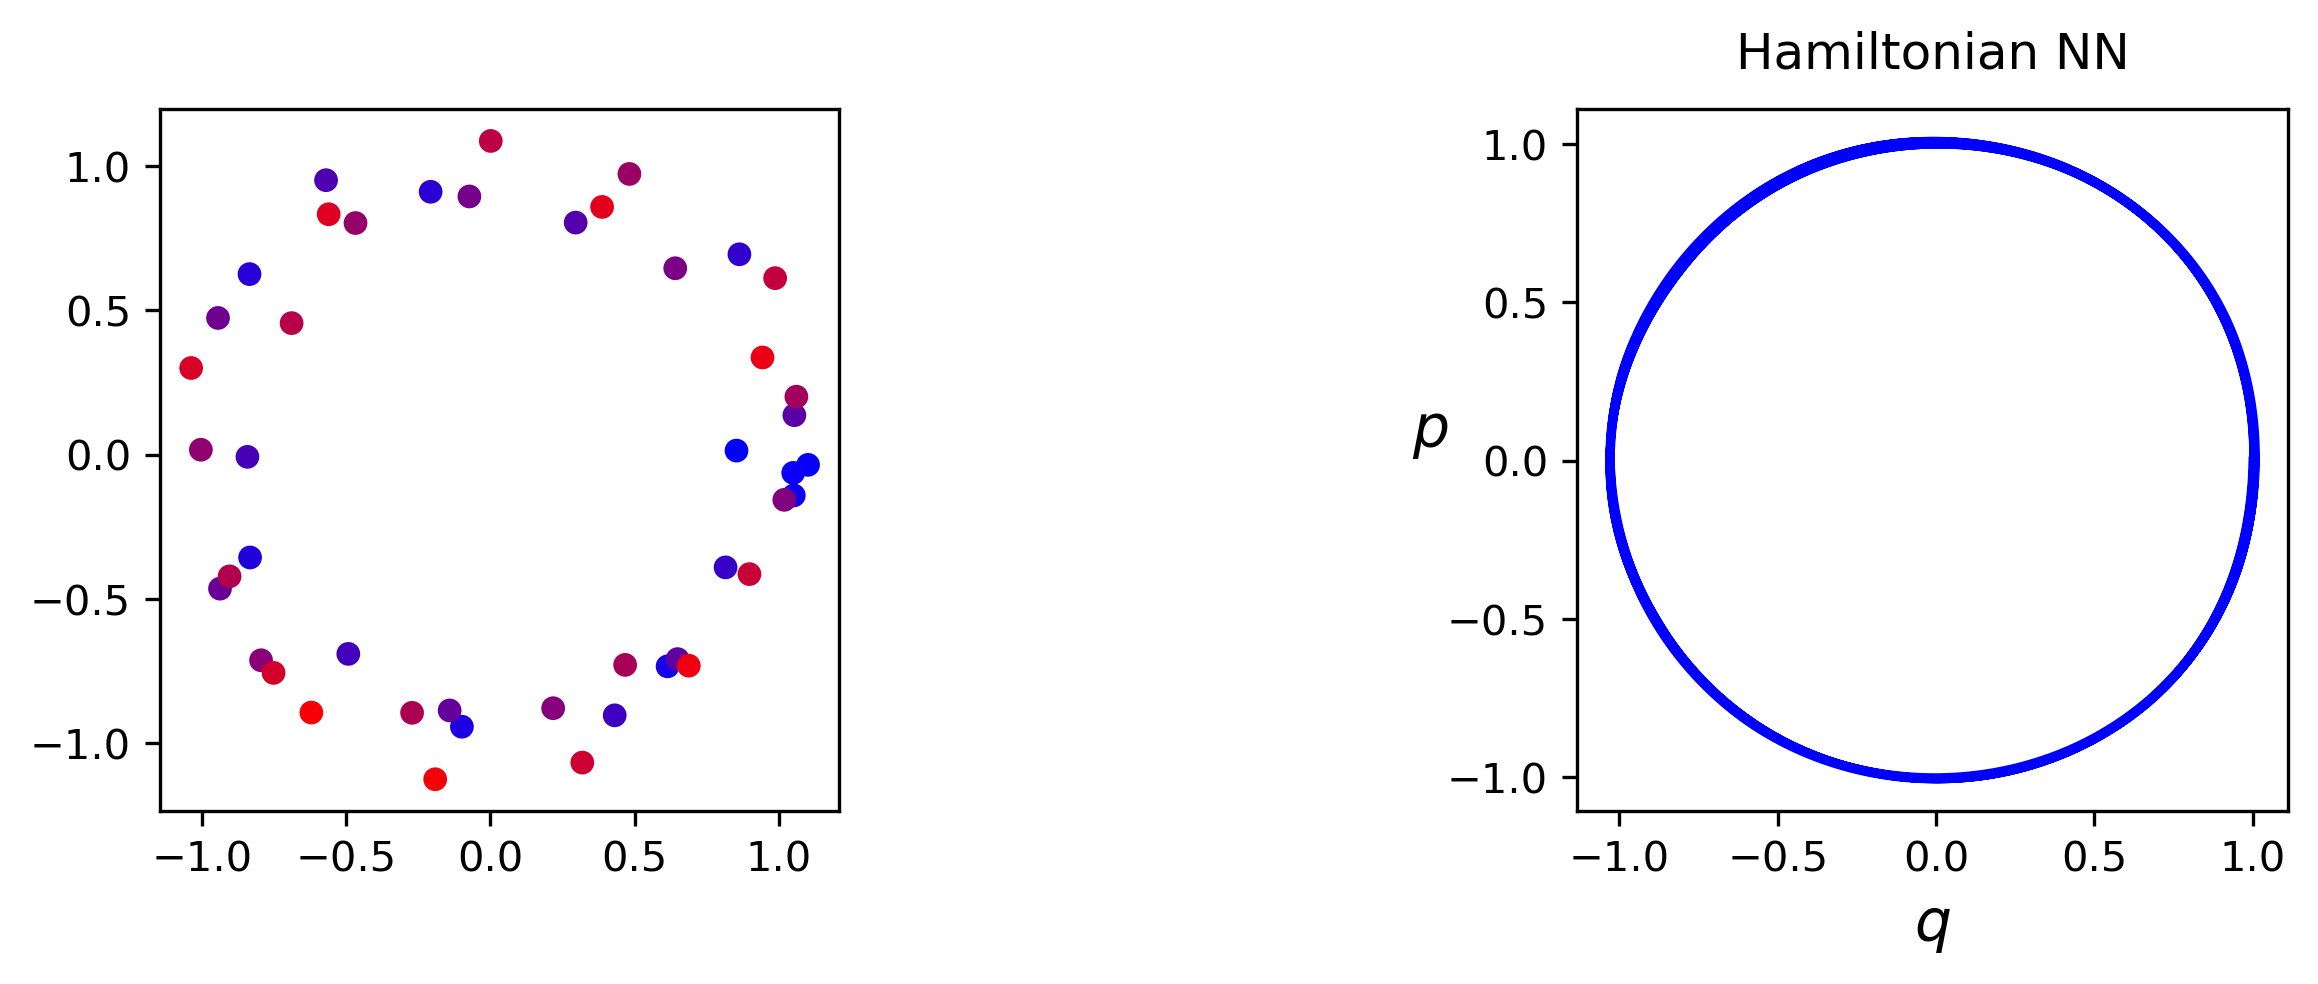

In [103]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)
fig.add_subplot(1, 2, 1, frameon=True)

q, p, dq, dp =trajectory(t_span, y0=y0)
N = len(q)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(q,p, s=22, label='data', c=point_colors)
plt.axis("scaled")
fig.add_subplot(1, 2, 2, frameon=True)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)

    
#plt.plot(y_new(0,:),y_new(1,:))    
plt.axis("scaled")
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

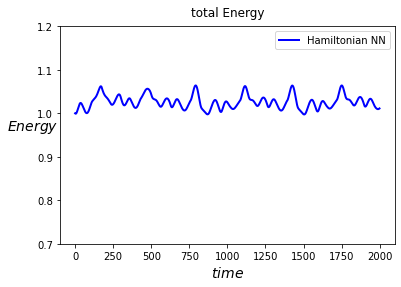

In [109]:
hnn_e = np.stack([Hamiltonian(c) for c in hnn_x])
plt.plot( hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlabel("$time$", fontsize=14)
plt.ylabel("$Energy$", rotation=0, fontsize=14)
plt.title("total Energy", pad=10)
plt.ylim(0.7,1.2)
plt.legend()